In [33]:
!pip install matplotsoccer
!pip install tables

import warnings

import matplotsoccer
import numpy as np
import pandas as pd
from ipywidgets import fixed, interact_manual, widgets
from tqdm.notebook import tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5966 sha256=c2ca9449842e72c6c1791a78fae7d19246edc069d6eb7e9f1e130bd11c17563c
  Stored in directory: /root/.cache/pip/wheels/ef/a9/d2/796b0ad28ffe440216ddaf7c9aa570dbdbfd67c3b208fd07ca
Successfully built matplotsoccer


In [ ]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

# Load dataset

First we load the SPADL dataset that was created in the tutorial1-run-pipeline.ipynb notebook. We first load the teams, players and games dataframes.

In [ ]:
df_teams = pd.read_hdf('/content/spadl.h5', key='teams')
df_players = pd.read_hdf('/content/spadl.h5', key='players')
df_games = pd.read_hdf('/content/spadl.h5', key='games')

FileNotFoundError: File /content/spadl.h5 does not exist

In [ ]:
df_games

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
0,2565922,795,181144,2018-05-20 18:45:00,676,687
1,2565925,795,181144,2018-05-20 16:30:00,679,701
2,2565919,795,181144,2018-05-20 14:15:00,678,691
3,2565924,795,181144,2018-05-20 10:00:00,674,677
4,2565927,795,181144,2018-05-19 18:45:00,682,675
...,...,...,...,...,...,...
59,2057966,28,10078,2018-06-16 10:00:00,4418,8493
60,2057960,28,10078,2018-06-15 18:00:00,9905,1598
61,2057961,28,10078,2018-06-15 15:00:00,16216,10840
62,2057955,28,10078,2018-06-15 12:00:00,16129,15670


We add the team names to the df_games dataframe such that we know which two teams played in which match.

In [ ]:
team_name_mapping = df_teams.set_index('team_id')['team_name'].to_dict()
df_games['home_team_name'] = df_games['home_team_id'].map(team_name_mapping)
df_games['away_team_name'] = df_games['away_team_id'].map(team_name_mapping)

## Load SPADL actions for all games

For each action, the dataset contains the following information for the action:

* game_id: a unique identifier of the game;
* team_id: a unique identifier of the team who performed the action;
* player_id: a unique identifier of the player who performed the action;
* period: 1 for the first half and 2 for the second half;
* seconds: the time elapsed in seconds since the start of the half;
* type_id: the identifier for the type of action;
* type_name: the name for the type of action;
* body_part_id: 0 for foot, 1 for head, 2 for other body part;
* result: the result of the action: 0 for failure, 1 for success;
* start_x: the x coordinate for the location where the action started, ranges from 0 to 105;
* start_y: the y coordinate for the location where the action started, ranges from 0 to 68;
* end_x: the x coordinate for the location where the action ended, ranges from 0 to 105;
* end_y: the y coordinate for the location where the action ended, ranges from 0 to 68.

The action types are:

    0: pass
    1: cross
    2: throw in
    3: freekick crossed
    4: freekick short
    5: corner crossed
    6: corner short
    7: take on
    8: foul
    9: tackle
    10: interception
    11: shot
    12: shot penalty
    13: shot freekick
    14: keeper save
    18: clearance
    21: dribble
    22: goalkick

We first load the actions for the selected game_id.

In [ ]:
global_df_actions = []
for game_id in df_games['game_id']:
  with pd.HDFStore('/content/spadl.h5') as spadlstore:
    df_actions = spadlstore[f'actions/game_{game_id}']
    df_actions = (
        df_actions.merge(spadlstore['actiontypes'], how='left')
        .merge(spadlstore['results'], how='left')
        .merge(spadlstore['bodyparts'], how='left')
        .merge(spadlstore['players'], how="left")
        .merge(spadlstore['teams'], how='left')
        .reset_index()
        .rename(columns={'index': 'action_id'})
    )
    global_df_actions.append(df_actions)

df_actions = pd.concat(global_df_actions)

In [ ]:
df_actions.keys()

Index(['action_id', 'game_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
       'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
       'short_name', 'first_name', 'last_name', 'birth_date',
       'short_team_name', 'team_name'],
      dtype='object')

In [ ]:
df_actions_arr= np.array(df_actions)

In [ ]:
possesion_loss_next_5 = []
for row_index in range(len(df_actions_arr)):
    check_arr = df_actions_arr[row_index + 1 :min(row_index+50,len(df_actions_arr))]
    if((check_arr[:,3] < df_actions_arr[row_index,3] + 5.0) & (check_arr[:,4] != df_actions_arr[row_index,4]) & (check_arr[:,1] == df_actions_arr[row_index,1]) & (check_arr[:,2] == df_actions_arr[row_index,2])).any():
        possesion_loss_next_5.append(1)
    else:
        possesion_loss_next_5.append(0)

print(sum(possesion_loss_next_5))


162491


In [ ]:
pass_with_shot_in_10_actions = []
for row_index in range(len(df_actions_arr)):
    if(df_actions_arr[row_index,13] != 'pass'):
        pass_with_shot_in_10_actions.append(0)
        continue

    check_arr = df_actions_arr[row_index + 1 :min(row_index+11,len(df_actions_arr))]

    if((check_arr[:,13] == 'shot') & (check_arr[:,1] == df_actions_arr[row_index,1]) & (check_arr[:,2] == df_actions_arr[row_index,2])).any():
        pass_with_shot_in_10_actions.append(1)
    else:
        pass_with_shot_in_10_actions.append(0)

print(sum(pass_with_shot_in_10_actions))

58809


In [ ]:
pass_with_shot_in_10_seconds = []
for row_index in range(len(df_actions_arr)):
    if(df_actions_arr[row_index,13] != 'pass'):
        pass_with_shot_in_10_seconds.append(0)
        continue

    check_arr = df_actions_arr[row_index + 1 :min(row_index+50,len(df_actions_arr))]

    if((check_arr[:,3] < df_actions_arr[row_index,3] + 10.0) & (check_arr[:,13] == 'shot') & (check_arr[:,1] == df_actions_arr[row_index,1]) & (check_arr[:,2] == df_actions_arr[row_index,2])).any():
        pass_with_shot_in_10_seconds.append(1)
    else:
        pass_with_shot_in_10_seconds.append(0)

print(sum(pass_with_shot_in_10_seconds))

18514


In [ ]:
isHomeTeam = []
GoalsScored = []
GoalsConceded = []
current_game_id = -1
for row_index in range(len(df_actions_arr)):
    if(current_game_id != df_actions_arr[row_index,1]):
         home_goals = 0
         away_goals = 0
    home_team_id = np.array(df_games[df_games['game_id'] == df_actions_arr[row_index,1]]['home_team_id'])
    isHomeTeam.append(1 if df_actions_arr[row_index,4] == home_team_id else 0)
    if (df_actions_arr[row_index,13] == 'shot') or (df_actions_arr[row_index,13] == 'shot_penalty') or (df_actions_arr[row_index,13] == 'shot_freekick'):
      if(df_actions_arr[row_index,14] == 'success'):
        if df_actions_arr[row_index,4] == home_team_id:
            home_goals += 1
        else:
            away_goals += 1

    if(df_actions_arr[row_index,14] == 'owngoal'):
        if df_actions_arr[row_index,4] == home_team_id:
            away_goals += 1
        else:
            home_goals += 1

    GoalsScored.append(home_goals if df_actions_arr[row_index,4] == home_team_id else away_goals)
    GoalsConceded.append(away_goals if df_actions_arr[row_index,4] == home_team_id else home_goals)
    current_game_id = df_actions_arr[row_index,1]

df_actions['isHomeTeam'] = isHomeTeam
df_actions['GoalsScored'] = GoalsScored
df_actions['GoalsConceded'] = GoalsConceded
df_actions

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name,isHomeTeam,GoalsScored,GoalsConceded
0,0,2565922.0,1.0,1.005442,687.0,3576.0,53.55,34.68,66.15,17.68,...,foot,Juanmi,Juan Miguel,Jiménez López,1993-05-20,Real Sociedad,Real Sociedad de Fútbol,0,0,0
1,1,2565922.0,1.0,4.151517,687.0,3828.0,66.15,17.68,30.45,62.56,...,foot,Raúl Navas,Raúl,Rodríguez Navas,1988-05-11,Real Sociedad,Real Sociedad de Fútbol,0,0,0
2,2,2565922.0,1.0,7.390181,687.0,261127.0,30.45,62.56,21.00,68.00,...,foot,A. Januzaj,Adnan,Januzaj,1995-02-05,Real Sociedad,Real Sociedad de Fútbol,0,0,0
3,3,2565922.0,1.0,23.291657,676.0,3269.0,22.05,68.00,31.50,65.96,...,other,Jordi Alba,Jordi,Alba Ramos,1989-03-21,Barcelona,FC Barcelona,1,0,0
4,4,2565922.0,1.0,24.254552,676.0,7972.0,30.45,66.64,33.60,66.64,...,foot,L. Suárez,Luis Alberto,Suárez Díaz,1987-01-24,Barcelona,FC Barcelona,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,1215,2057954.0,2.0,2868.496551,14358.0,103682.0,76.65,19.04,81.90,20.40,...,foot,R. Zobnin,Roman,Zobnin,1994-02-11,Russia,Russia,1,4,0
1216,1216,2057954.0,2.0,2870.980334,16521.0,122577.0,81.90,20.40,80.85,25.16,...,foot,Taisir Al Jassim,Taisir Jabir,Al Jassim,1984-07-25,Saudi Arabia,Saudi Arabia,0,0,4
1217,1217,2057954.0,2.0,2872.843120,16521.0,122577.0,80.85,25.16,80.85,25.16,...,foot,Taisir Al Jassim,Taisir Jabir,Al Jassim,1984-07-25,Saudi Arabia,Saudi Arabia,0,0,4
1218,1218,2057954.0,2.0,2939.438099,14358.0,257800.0,85.05,22.44,105.00,30.60,...,foot,A. Golovin,Aleksandr,Golovin,1996-05-30,Russia,Russia,1,5,0


In [ ]:
df_actions['possession_loss_in_next_5_seconds'] = possesion_loss_next_5
df_actions['pass_with_shot_in_10_seconds'] = pass_with_shot_in_10_seconds
df_actions['pass_with_shot_in_10_actions'] = pass_with_shot_in_10_actions


# Plotting the values of the 3 features



In [44]:
import matplotlib.pyplot as plt
import scipy

def plot_starting_position_heatmap(df_actions_to_plot,Color="Blues"):
    # Extract the starting positions
    start_positions = df_actions_to_plot[['start_x', 'start_y']]
    hm = matplotsoccer.count(start_positions['start_x'],start_positions['start_y'],n=25,m=25) # Construct a 25x25 heatmap from x,y-coordinates
    hm = scipy.ndimage.gaussian_filter(hm,1) # blur the heatmap
    matplotsoccer.heatmap(hm, cbar=True, cmap=Color) # plot the heatmap



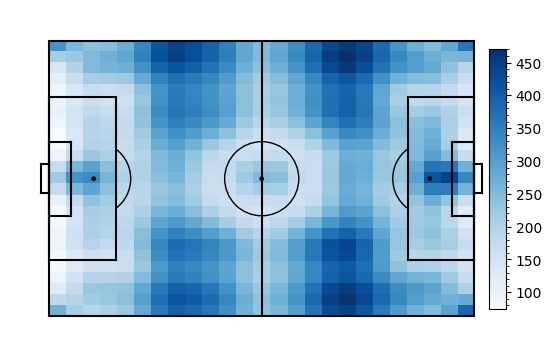

In [ ]:
plot_starting_position_heatmap(df_actions[df_actions['possession_loss_in_next_5_seconds'] == 1])

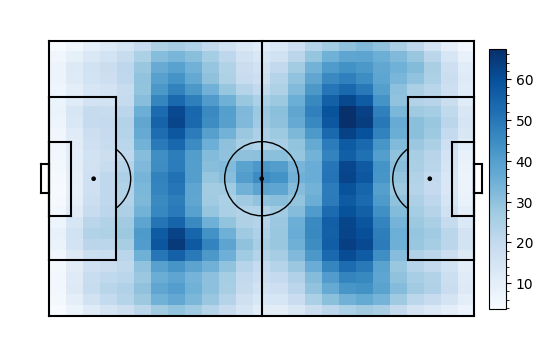

In [ ]:
plot_starting_position_heatmap(df_actions[df_actions['pass_with_shot_in_10_seconds'] == 1])

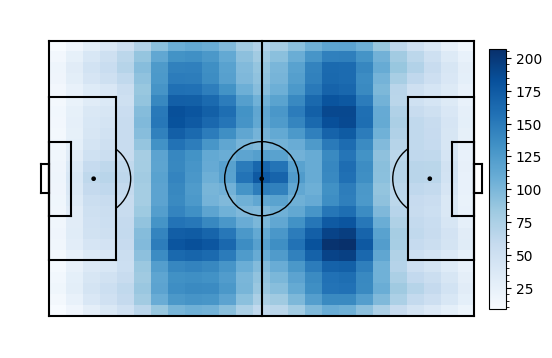

In [ ]:
plot_starting_position_heatmap(df_actions[df_actions['pass_with_shot_in_10_actions'] == 1])

In [ ]:
df_actions.to_hdf('/content/drive/MyDrive/Friends of Tracking/data_analytics_full_features.h5', key='data', mode='w')


# Load the Full set of Data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data =pd.read_hdf('/content/drive/MyDrive/Friends of Tracking/data_analytics_full_features.h5', key='data')
data.keys()

Index(['action_id', 'game_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
       'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
       'short_name', 'first_name', 'last_name', 'birth_date',
       'short_team_name', 'team_name', 'isHomeTeam', 'GoalsScored',
       'GoalsConceded', 'possession_loss_in_next_5_seconds',
       'pass_with_shot_in_10_seconds', 'pass_with_shot_in_10_actions'],
      dtype='object')

In [6]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68

In [7]:
GOAL_X = PITCH_LENGTH
GOAL_Y = PITCH_WIDTH / 2

In [8]:
for side in ['start', 'end']:
    diff_x = GOAL_X - data[f'{side}_x']
    diff_y = GOAL_Y - data[f'{side}_y']
    data[f'{side}_distance_to_goal'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
    data[f'{side}_angle_to_goal'] = np.arctan2(diff_y, diff_x)

In [9]:
data

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,isHomeTeam,GoalsScored,GoalsConceded,possession_loss_in_next_5_seconds,pass_with_shot_in_10_seconds,pass_with_shot_in_10_actions,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal
0,0,2565922.0,1.0,1.005442,687.0,3576.0,53.55,34.68,66.15,17.68,...,0,0,0,0,0,0,51.454493,-0.013216,42.138639,0.397694
1,1,2565922.0,1.0,4.151517,687.0,3828.0,66.15,17.68,30.45,62.56,...,0,0,0,0,0,0,42.138639,0.397694,79.833427,-0.365852
2,2,2565922.0,1.0,7.390181,687.0,261127.0,30.45,62.56,21.00,68.00,...,0,0,0,0,0,0,79.833427,-0.365852,90.620086,-0.384605
3,3,2565922.0,1.0,23.291657,676.0,3269.0,22.05,68.00,31.50,65.96,...,1,0,0,1,0,0,89.647658,-0.388999,80.147936,-0.410167
4,4,2565922.0,1.0,24.254552,676.0,7972.0,30.45,66.64,33.60,66.64,...,1,0,0,1,0,0,81.382259,-0.412685,78.506876,-0.428778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,1215,2057954.0,2.0,2868.496551,14358.0,103682.0,76.65,19.04,81.90,20.40,...,1,4,0,1,0,0,32.055017,0.485553,26.806156,0.532102
1216,1216,2057954.0,2.0,2870.980334,16521.0,122577.0,81.90,20.40,80.85,25.16,...,0,0,4,0,0,0,26.806156,0.532102,25.717078,0.350897
1217,1217,2057954.0,2.0,2872.843120,16521.0,122577.0,80.85,25.16,80.85,25.16,...,0,0,4,0,0,0,25.717078,0.350897,25.717078,0.350897
1218,1218,2057954.0,2.0,2939.438099,14358.0,257800.0,85.05,22.44,105.00,30.60,...,1,5,0,0,0,0,23.057235,0.525171,3.400000,1.570796


In [10]:
end_times = (data['period_id'] == 1)*45*60 + (data['period_id'] == 2)*45*60 + (data['period_id'] == 3)*15*60 + (data['period_id'] == 4)*15*60 + (data['period_id'] == 5)*data['time_seconds']

In [11]:
data['time_to_end'] = end_times - data['time_seconds']

In [12]:
features_to_delay = ['time_seconds', 'isHomeTeam', 'start_distance_to_goal','start_angle_to_goal','end_distance_to_goal','end_angle_to_goal']

feature_indexes = [data.columns.get_loc(f) for f in features_to_delay]


In [13]:
data_array = data.to_numpy()
delays = 10
new_data_array = []
for row_index in range(len(data_array)):
        start_index = row_index - (delays - 1)
        new_rows = data_array[max(0,start_index):row_index+1]
        game_id = data_array[row_index, 1]
        period_id = data_array[row_index, 2]
        filtered_rows = new_rows[(new_rows[:, 1] == game_id) & (new_rows[:, 2] == period_id)]
        assert len(filtered_rows) > 0
        while len(filtered_rows) < delays:
          filtered_rows = np.vstack((filtered_rows[0], filtered_rows))
        filtered_rows = filtered_rows[0:delays-1,feature_indexes]
        new_data_array.append(filtered_rows.reshape(1, -1))

new_data_array = np.vstack(new_data_array)

In [14]:
features_to_delay[1] = 'isSameTeam'
new_feature_names = []
delays = 10
for delay in range(delays - 1 ,0,-1):
    new_features = [f'{f}-{delay}' for f in features_to_delay]
    new_feature_names.append(new_features)

new_feature_names = np.hstack(new_feature_names)

In [15]:
new_data_array = np.array(new_data_array,dtype=np.float32)

In [16]:
data[new_feature_names] = new_data_array

In [17]:
local_team_features = [f'isSameTeam-{delay}' for delay in range(1,delays-1)]
for f in local_team_features:
    data[f] = (data[f] == data['isHomeTeam'])

In [18]:
data['isHomeTeam'] = (data['isHomeTeam'] == 1.0)
data

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,start_distance_to_goal-2,start_angle_to_goal-2,end_distance_to_goal-2,end_angle_to_goal-2,time_seconds-1,isSameTeam-1,start_distance_to_goal-1,start_angle_to_goal-1,end_distance_to_goal-1,end_angle_to_goal-1
0,0,2565922.0,1.0,1.005442,687.0,3576.0,53.55,34.68,66.15,17.68,...,51.454494,-0.013216,42.138638,0.397694,1.005442,True,51.454494,-0.013216,42.138638,0.397694
1,1,2565922.0,1.0,4.151517,687.0,3828.0,66.15,17.68,30.45,62.56,...,51.454494,-0.013216,42.138638,0.397694,1.005442,True,51.454494,-0.013216,42.138638,0.397694
2,2,2565922.0,1.0,7.390181,687.0,261127.0,30.45,62.56,21.00,68.00,...,51.454494,-0.013216,42.138638,0.397694,4.151517,True,42.138638,0.397694,79.833427,-0.365852
3,3,2565922.0,1.0,23.291657,676.0,3269.0,22.05,68.00,31.50,65.96,...,42.138638,0.397694,79.833427,-0.365852,7.390181,False,79.833427,-0.365852,90.620087,-0.384605
4,4,2565922.0,1.0,24.254552,676.0,7972.0,30.45,66.64,33.60,66.64,...,79.833427,-0.365852,90.620087,-0.384605,23.291656,True,89.647659,-0.388999,80.147934,-0.410167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,1215,2057954.0,2.0,2868.496551,14358.0,103682.0,76.65,19.04,81.90,20.40,...,50.020077,-0.163867,33.913609,0.284537,2865.964844,True,33.913609,0.284537,32.055016,0.485553
1216,1216,2057954.0,2.0,2870.980334,16521.0,122577.0,81.90,20.40,80.85,25.16,...,33.913609,0.284537,32.055016,0.485553,2868.496582,False,32.055016,0.485553,26.806156,0.532102
1217,1217,2057954.0,2.0,2872.843120,16521.0,122577.0,80.85,25.16,80.85,25.16,...,32.055016,0.485553,26.806156,0.532102,2870.980225,True,26.806156,0.532102,25.717077,0.350897
1218,1218,2057954.0,2.0,2939.438099,14358.0,257800.0,85.05,22.44,105.00,30.60,...,26.806156,0.532102,25.717077,0.350897,2872.843018,False,25.717077,0.350897,25.717077,0.350897


In [19]:
data.drop(columns=['action_id','game_id','player_id','team_id','type_id', 'result_id', 'bodypart_name','bodypart_id', 'short_name', 'first_name', 'last_name', 'birth_date',
       'short_team_name', 'team_name','start_x', 'start_y', 'end_x', 'end_y'], inplace=True)

In [20]:
data

,period_id,time_seconds,type_name,result_name,isHomeTeam,GoalsScored,GoalsConceded,possession_loss_in_next_5_seconds,pass_with_shot_in_10_seconds,pass_with_shot_in_10_actions,...,start_distance_to_goal-2,start_angle_to_goal-2,end_distance_to_goal-2,end_angle_to_goal-2,time_seconds-1,isSameTeam-1,start_distance_to_goal-1,start_angle_to_goal-1,end_distance_to_goal-1,end_angle_to_goal-1
0,1.0,1.005442,pass,success,False,0,0,0,0,0,...,51.454494,-0.013216,42.138638,0.397694,1.005442,True,51.454494,-0.013216,42.138638,0.397694
1,1.0,4.151517,pass,success,False,0,0,0,0,0,...,51.454494,-0.013216,42.138638,0.397694,1.005442,True,51.454494,-0.013216,42.138638,0.397694
2,1.0,7.390181,pass,success,False,0,0,0,0,0,...,51.454494,-0.013216,42.138638,0.397694,4.151517,True,42.138638,0.397694,79.833427,-0.365852
3,1.0,23.291657,throw_in,success,True,0,0,1,0,0,...,42.138638,0.397694,79.833427,-0.365852,7.390181,False,79.833427,-0.365852,90.620087,-0.384605
4,1.0,24.254552,pass,fail,True,0,0,1,0,0,...,79.833427,-0.365852,90.620087,-0.384605,23.291656,True,89.647659,-0.388999,80.147934,-0.410167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,2.0,2868.496551,pass,success,True,4,0,1,0,0,...,50.020077,-0.163867,33.913609,0.284537,2865.964844,True,33.913609,0.284537,32.055016,0.485553
1216,2.0,2870.980334,tackle,fail,False,0,4,0,0,0,...,33.913609,0.284537,32.055016,0.485553,2868.496582,False,32.055016,0.485553,26.806156,0.532102
1217,2.0,2872.843120,foul,success,False,0,4,0,0,0,...,32.055016,0.485553,26.806156,0.532102,2870.980225,True,26.806156,0.532102,25.717077,0.350897
1218,2.0,2939.438099,shot_freekick,success,True,5,0,0,0,0,...,26.806156,0.532102,25.717077,0.350897,2872.843018,False,25.717077,0.350897,25.717077,0.350897


In [21]:
dummify = ['type_name','result_name', 'period_id']

for col in dummify:
  data[col] = data[col].astype('category')
  data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1).drop(col, axis=1)

data


,time_seconds,isHomeTeam,GoalsScored,GoalsConceded,possession_loss_in_next_5_seconds,pass_with_shot_in_10_seconds,pass_with_shot_in_10_actions,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,...,type_name_throw_in,result_name_fail,result_name_offside,result_name_owngoal,result_name_success,period_id_1.0,period_id_2.0,period_id_3.0,period_id_4.0,period_id_5.0
0,1.005442,False,0,0,0,0,0,51.454493,-0.013216,42.138639,...,False,False,False,False,True,True,False,False,False,False
1,4.151517,False,0,0,0,0,0,42.138639,0.397694,79.833427,...,False,False,False,False,True,True,False,False,False,False
2,7.390181,False,0,0,0,0,0,79.833427,-0.365852,90.620086,...,False,False,False,False,True,True,False,False,False,False
3,23.291657,True,0,0,1,0,0,89.647658,-0.388999,80.147936,...,True,False,False,False,True,True,False,False,False,False
4,24.254552,True,0,0,1,0,0,81.382259,-0.412685,78.506876,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,2868.496551,True,4,0,1,0,0,32.055017,0.485553,26.806156,...,False,False,False,False,True,False,True,False,False,False
1216,2870.980334,False,0,4,0,0,0,26.806156,0.532102,25.717078,...,False,True,False,False,False,False,True,False,False,False
1217,2872.843120,False,0,4,0,0,0,25.717078,0.350897,25.717078,...,False,False,False,False,True,False,True,False,False,False
1218,2939.438099,True,5,0,0,0,0,23.057235,0.525171,3.400000,...,False,False,False,False,True,False,True,False,False,False


In [22]:
mv1 = data['pass_with_shot_in_10_actions']
mv2 = data['pass_with_shot_in_10_seconds']
mv3 = data['possession_loss_in_next_5_seconds']
data.drop(columns = ['pass_with_shot_in_10_actions', 'pass_with_shot_in_10_seconds', 'possession_loss_in_next_5_seconds'], inplace=True)
data['pass_with_shot_in_10_actions'] = mv1
data['pass_with_shot_in_10_seconds'] = mv2
data['possession_loss_in_next_5_seconds'] = mv3
data

,time_seconds,isHomeTeam,GoalsScored,GoalsConceded,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal,time_to_end,time_seconds-9,...,result_name_owngoal,result_name_success,period_id_1.0,period_id_2.0,period_id_3.0,period_id_4.0,period_id_5.0,pass_with_shot_in_10_actions,pass_with_shot_in_10_seconds,possession_loss_in_next_5_seconds
0,1.005442,False,0,0,51.454493,-0.013216,42.138639,0.397694,2698.994558,1.005442,...,False,True,True,False,False,False,False,0,0,0
1,4.151517,False,0,0,42.138639,0.397694,79.833427,-0.365852,2695.848483,1.005442,...,False,True,True,False,False,False,False,0,0,0
2,7.390181,False,0,0,79.833427,-0.365852,90.620086,-0.384605,2692.609819,1.005442,...,False,True,True,False,False,False,False,0,0,0
3,23.291657,True,0,0,89.647658,-0.388999,80.147936,-0.410167,2676.708343,1.005442,...,False,True,True,False,False,False,False,0,0,1
4,24.254552,True,0,0,81.382259,-0.412685,78.506876,-0.428778,2675.745448,1.005442,...,False,False,True,False,False,False,False,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,2868.496551,True,4,0,32.055017,0.485553,26.806156,0.532102,-168.496551,2852.481201,...,False,True,False,True,False,False,False,0,0,1
1216,2870.980334,False,0,4,26.806156,0.532102,25.717078,0.350897,-170.980334,2852.481201,...,False,False,False,True,False,False,False,0,0,0
1217,2872.843120,False,0,4,25.717078,0.350897,25.717078,0.350897,-172.843120,2855.273926,...,False,True,False,True,False,False,False,0,0,0
1218,2939.438099,True,5,0,23.057235,0.525171,3.400000,1.570796,-239.438099,2856.818359,...,False,True,False,True,False,False,False,0,0,0


In [23]:
for col in data.columns:
  if data[col].dtype == 'object':
    print(col)

In [24]:
data.to_hdf('/content/drive/MyDrive/Friends of Tracking/final_features_dummified_no_object.h5', key='data', mode='w')

In [53]:
import numpy as np
import pandas as pd
final_data =pd.read_hdf('/content/drive/MyDrive/Friends of Tracking/final_features_dummified_no_object.h5', key='data')
final_data.keys()

Index(['time_seconds', 'isHomeTeam', 'GoalsScored', 'GoalsConceded',
       'start_distance_to_goal', 'start_angle_to_goal', 'end_distance_to_goal',
       'end_angle_to_goal', 'time_to_end', 'time_seconds-9', 'isSameTeam-9',
       'start_distance_to_goal-9', 'start_angle_to_goal-9',
       'end_distance_to_goal-9', 'end_angle_to_goal-9', 'time_seconds-8',
       'isSameTeam-8', 'start_distance_to_goal-8', 'start_angle_to_goal-8',
       'end_distance_to_goal-8', 'end_angle_to_goal-8', 'time_seconds-7',
       'isSameTeam-7', 'start_distance_to_goal-7', 'start_angle_to_goal-7',
       'end_distance_to_goal-7', 'end_angle_to_goal-7', 'time_seconds-6',
       'isSameTeam-6', 'start_distance_to_goal-6', 'start_angle_to_goal-6',
       'end_distance_to_goal-6', 'end_angle_to_goal-6', 'time_seconds-5',
       'isSameTeam-5', 'start_distance_to_goal-5', 'start_angle_to_goal-5',
       'end_distance_to_goal-5', 'end_angle_to_goal-5', 'time_seconds-4',
       'isSameTeam-4', 'start_distance_t

In [54]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_data, test_size=0.2)
train

,time_seconds,isHomeTeam,GoalsScored,GoalsConceded,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal,time_to_end,time_seconds-9,...,result_name_owngoal,result_name_success,period_id_1.0,period_id_2.0,period_id_3.0,period_id_4.0,period_id_5.0,pass_with_shot_in_10_actions,pass_with_shot_in_10_seconds,possession_loss_in_next_5_seconds
1001,2417.488129,False,3,3,74.446802,-0.287082,73.754352,-0.083074,282.511871,2392.645996,...,False,True,False,True,False,False,False,1,1,0
608,2722.381211,True,1,0,105.000000,0.000000,105.000000,0.000000,-22.381211,2709.106445,...,False,True,True,False,False,False,False,0,0,0
578,2331.752883,False,1,1,56.150449,0.133611,62.710538,-0.240879,368.247117,2278.393555,...,False,True,True,False,False,False,False,0,0,1
1213,2937.051888,False,1,1,29.826715,-1.095453,30.336618,-0.249136,-237.051888,2912.837891,...,False,True,False,True,False,False,False,0,0,0
263,1166.204455,True,1,0,22.784767,0.398437,30.082821,1.251253,1533.795545,1143.207520,...,False,True,True,False,False,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,79.172145,False,1,0,50.790487,-0.597177,43.915942,-0.770906,2620.827855,50.015533,...,False,True,False,True,False,False,False,0,0,0
1148,2627.679746,True,1,1,67.203440,0.010119,71.041825,0.281277,72.320254,2583.709961,...,False,False,False,True,False,False,False,0,0,1
968,1607.852509,True,0,1,34.000000,-1.570796,6.648977,-0.660647,1092.147491,1546.729004,...,False,True,False,True,False,False,False,0,0,0
462,1784.758722,False,0,0,8.427479,-0.080776,62.035191,0.266210,915.241278,1752.135498,...,False,True,True,False,False,False,False,0,0,0


In [55]:
import statsmodels.api as sm

predict_features = ['pass_with_shot_in_10_actions','pass_with_shot_in_10_seconds', 'possession_loss_in_next_5_seconds']
# defining the dependent and independent variables
ytrain = train[predict_features]
ytest = test[predict_features]
Xtrain = train.drop(columns=predict_features, inplace=False)
Xtest = test.drop(columns=predict_features, inplace=False)
Xtrain

,time_seconds,isHomeTeam,GoalsScored,GoalsConceded,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal,time_to_end,time_seconds-9,...,type_name_throw_in,result_name_fail,result_name_offside,result_name_owngoal,result_name_success,period_id_1.0,period_id_2.0,period_id_3.0,period_id_4.0,period_id_5.0
1001,2417.488129,False,3,3,74.446802,-0.287082,73.754352,-0.083074,282.511871,2392.645996,...,False,False,False,False,True,False,True,False,False,False
608,2722.381211,True,1,0,105.000000,0.000000,105.000000,0.000000,-22.381211,2709.106445,...,False,False,False,False,True,True,False,False,False,False
578,2331.752883,False,1,1,56.150449,0.133611,62.710538,-0.240879,368.247117,2278.393555,...,False,False,False,False,True,True,False,False,False,False
1213,2937.051888,False,1,1,29.826715,-1.095453,30.336618,-0.249136,-237.051888,2912.837891,...,False,False,False,False,True,False,True,False,False,False
263,1166.204455,True,1,0,22.784767,0.398437,30.082821,1.251253,1533.795545,1143.207520,...,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,79.172145,False,1,0,50.790487,-0.597177,43.915942,-0.770906,2620.827855,50.015533,...,False,False,False,False,True,False,True,False,False,False
1148,2627.679746,True,1,1,67.203440,0.010119,71.041825,0.281277,72.320254,2583.709961,...,False,True,False,False,False,False,True,False,False,False
968,1607.852509,True,0,1,34.000000,-1.570796,6.648977,-0.660647,1092.147491,1546.729004,...,False,False,False,False,True,False,True,False,False,False
462,1784.758722,False,0,0,8.427479,-0.080776,62.035191,0.266210,915.241278,1752.135498,...,False,False,False,False,True,True,False,False,False,False


In [56]:
for col in Xtrain.columns:
    Xtrain[col] = Xtrain[col].astype('float32')
    Xtest[col] = Xtest[col].astype('float32')

for col in ytrain.columns:
    ytrain[col] = ytrain[col].astype('float32')
    ytest[col] = ytest[col].astype('float32')

<ipython-input-56-483893c745b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytrain[col] = ytrain[col].astype('float32')
<ipython-input-56-483893c745b3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytest[col] = ytest[col].astype('float32')
<ipython-input-56-483893c745b3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [28]:
# building the model and fitting the data
log_reg_pos_loss = sm.Logit(ytrain['possession_loss_in_next_5_seconds'], Xtrain).fit()

         Current function value: 0.472012
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
print(log_reg_pos_loss.summary())

                                   Logit Regression Results                                  
Dep. Variable:     possession_loss_in_next_5_seconds   No. Observations:               494840
Model:                                         Logit   Df Residuals:                   494752
Method:                                          MLE   Df Model:                           87
Date:                               Thu, 23 May 2024   Pseudo R-squ.:                  0.1800
Time:                                       13:43:37   Log-Likelihood:            -2.3357e+05
converged:                                     False   LL-Null:                   -2.8484e+05
Covariance Type:                           nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
time_seconds                  -0.0029      0.002     -1.29

In [36]:
#Testing Accuracy
yhat = log_reg_pos_loss.predict(Xtest)
pred_y = np.where(yhat > 0.5, 1.0, 0)
print("Test Accuracy for predicting possession loss in next 5_seconds: ", np.sum(pred_y == np.array(ytest['possession_loss_in_next_5_seconds']))/pred_y.shape[0])

Test Accuracy for predicting possession loss in next 5_seconds:  0.8030086249403853


In [63]:
test['start_x'] = test['start_distance_to_goal']*np.cos(test['start_angle_to_goal'])
test['start_y'] = test['start_distance_to_goal']*np.sin(test['start_angle_to_goal'])

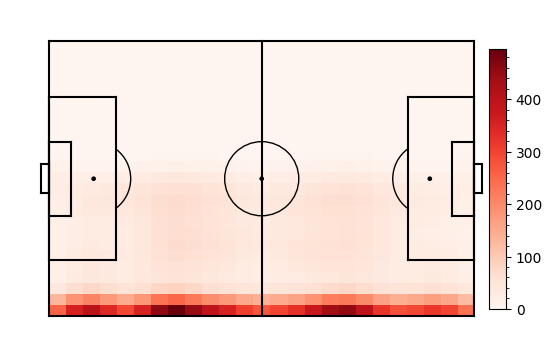

In [46]:
plot_starting_position_heatmap(test[~(np.array(ytest['possession_loss_in_next_5_seconds']) == pred_y)], Color="Reds")

In [60]:
# building the model and fitting the data
log_reg_shot_in_10_seconds = sm.Logit(ytrain['pass_with_shot_in_10_seconds'], Xtrain).fit(method='bfgs')
print(log_reg_shot_in_10_seconds.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.127628
         Iterations: 35
         Function evaluations: 55
         Gradient evaluations: 47


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                Logit Regression Results                                
Dep. Variable:     pass_with_shot_in_10_seconds   No. Observations:               494840
Model:                                    Logit   Df Residuals:                   494752
Method:                                     MLE   Df Model:                           87
Date:                          Thu, 23 May 2024   Pseudo R-squ.:                 0.05121
Time:                                  14:03:12   Log-Likelihood:                -63155.
converged:                                False   LL-Null:                       -66564.
Covariance Type:                      nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
time_seconds                  -0.0322      0.005     -7.075      0.000      -0.041      -0.023
isH

In [61]:
#Testing Accuracy
yhat = log_reg_shot_in_10_seconds.predict(Xtest)
pred_y = np.where(yhat > 0.5, 1.0, 0)
print("Test Accuracy for predicting passes with shots in the next 10 seconds: ", np.sum(pred_y == np.array(ytest['pass_with_shot_in_10_seconds']))/pred_y.shape[0])

Test Accuracy for predicting passes with shots in the next 10 seconds:  0.9700592509962735


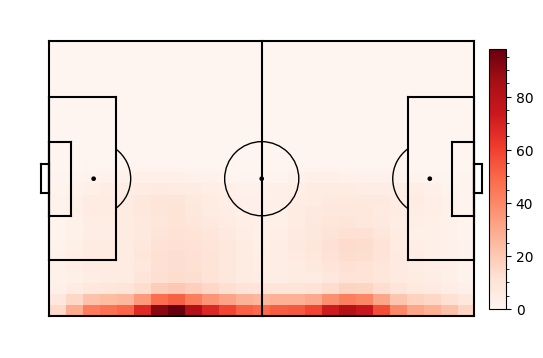

In [64]:
plot_starting_position_heatmap(test[~(np.array(ytest['pass_with_shot_in_10_seconds']) == pred_y)], Color="Reds")

In [65]:
# building the model and fitting the data
log_reg_shot_in_10_actions = sm.Logit(ytrain['pass_with_shot_in_10_actions'], Xtrain).fit()
print(log_reg_shot_in_10_actions.summary())

         Current function value: 0.270874
         Iterations: 35


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                Logit Regression Results                                
Dep. Variable:     pass_with_shot_in_10_actions   No. Observations:               494840
Model:                                    Logit   Df Residuals:                   494752
Method:                                     MLE   Df Model:                           87
Date:                          Thu, 23 May 2024   Pseudo R-squ.:                  0.1382
Time:                                  14:06:03   Log-Likelihood:            -1.3404e+05
converged:                                False   LL-Null:                   -1.5553e+05
Covariance Type:                      nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
time_seconds                  -0.0154     24.621     -0.001      1.000     -48.272      48.242
isH

In [66]:
#Testing Accuracy
yhat = log_reg_shot_in_10_actions.predict(Xtest)
pred_y = np.where(yhat > 0.5, 1.0, 0)
print("Test Accuracy for predicting passes with shots in the next 10 actions: ", np.sum(pred_y == np.array(ytest['pass_with_shot_in_10_actions']))/pred_y.shape[0])

Test Accuracy for predicting passes with shots in the next 10 actions:  0.9052469060956584


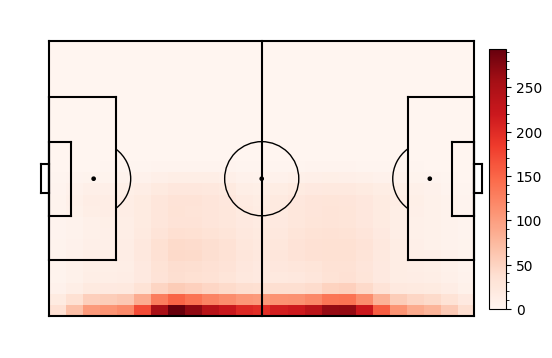

In [67]:
plot_starting_position_heatmap(test[~(np.array(ytest['pass_with_shot_in_10_actions']) == pred_y)], Color="Reds")